# Cross-Validation using Decision Trees and Logistic Regression (with Scaling)

This Jupyter Notebook uses cross-validation for evaluation of model performing, using 2 Machine Learning Classification Models: Decision Tree and Logistic Regression (with scaling applied to the input data).

## Approach
* Evaluations of classification performed were performed using 2 sample datasets:
    * sklearn's Iris sample dataset, consisting of 150 sample data points for 3 varieties of iris flowers
    * voice dataset, containing 3168 sample data points of male and female speakers

* Performance was evaluated based upon:
    * Classification model score for the test data
    * Time required to fit the model with training data
    
* For each Classification model, evaluations were performed with tuning of key parameters:
    * Decision Tree: Maximum Tree Depth
    * Logistic Regression: Solver algorithm
    
## Results
* Refer to the Figure and Table of Evaluation results provided below
* Both Decision Tree and Logistic Regression models performed well for both the Iris and Voice datasets, with Decision Tree show a significant decrease in performance only when Maximum Tree Depth was severely restricted.
* For these datasets, the Decision Tree classifier model fit the data more quickly than the Logistic Regression classifier for comparable performance levels.
* The Decision Tree classifier showed significant degradation in performance when Maximum Tree Depth was restricted when using the Iris dataset (4 features, 1 output with 3 classes), but showed almost no degradation in performance with Max Tree Depth restricted when using the Voice dataset (20 features, 1 output with 2 classes).  This classifier required much more fit time with the Voice dataset vs. the Iris dataset.  An examination of decision trees generated for each dataset might provide insight on these observations.
* The Logistic Regression classifier required more fit time than all but the slowest tests with the Decision Tree classifier.  The fastest Fit Time was obtained using lbfgs solver for the Iris dataset and liblinear solver for the Voice dataset.  Investigating the algorithmic differences in these solvers may provide some explanation of both the fit time differences.


| Figure: Cross-Validation Scoring for Decision Tree and Logistic Regression |
| :----------: |
| ![Figure: Cross-Validation Scoring for Decision Tree and Logistic Regression is Loading...](docs/Figure-Cross_Validation_Comparison_DecisionTree_and_LogisticRegression.png "Figure: Cross-Validation Scoring for Decision Tree and Logistic Regression") |

| Table: Cross-Validation Scoring for Decision Tree and Logistic Regression |
| :----------: |
| ![Table: Cross-Validation Model Performance for Decision Tree and Logistic Regression is Loading...](docs/Table-Cross_Validation_Comparison_DecisionTree_and_LogisticRegression.png "Table: Cross-Validation Scoring for Decision Tree and Logistic Regression") |


# Dependencies

In [1]:
%matplotlib inline
# %matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D    # Support 3D graphing

import numpy as np
import pandas as pd
import math

from pprint import pprint

# Visualization
import graphviz
import pydotplus

# Machine Learning - Linear Models - Regression
from sklearn.linear_model import LinearRegression  # TBD
from sklearn.linear_model import Lasso             # TBD
from sklearn.linear_model import Ridge             # TBD
from sklearn.linear_model import ElasticNet        # TBD

# Machine Learning - Linear Models - Classification
from sklearn.linear_model import LogisticRegression   # Linear model for classification

# Machine Learning - Decision Trees and Random Forests - Classification
from sklearn import tree                             # Decision Tree Classifer
from sklearn.ensemble import RandomForestClassifier  # Random Forest Classifer

# Machine Learning - Data Preparation and Pre-Processing
from sklearn.model_selection import train_test_split # Split data into training and testing samples
from sklearn.model_selection import cross_val_score  # Score a model using k-fold or other cross validation

from sklearn.preprocessing import OneHotEncoder   # Convert categorical integer features (X) to One-Hot encoded values
from sklearn.preprocessing import LabelEncoder    # Convert categorical labeled values to categorical integer values
from sklearn.preprocessing import LabelBinarizer  # Convert categorical labeled values to Binary encoded values

from sklearn.preprocessing import StandardScaler  # Scale numerical features to standard normal distribution
from sklearn.preprocessing import MinMaxScaler    # Scale numerical values based upon mix/max values

# Machine Learning - Quantify Model Performance
from sklearn.metrics import mean_squared_error   # Mean Squared Error (MSE) metric
from sklearn.metrics import r2_score             # R-squared (Coefficient of Determination) metric
from sklearn.metrics import confusion_matrix     # Generate a confusion matrix (actual vs. predicted counts)

# Machine Learning - Dataset Generation
from sklearn.datasets import make_regression     # Generate linear data
from sklearn.datasets import make_s_curve        # Generate nonlinear data
from sklearn.datasets import make_blobs          # Generate blobs for classification
from sklearn.datasets import make_circles        # Generate circles for classification
from sklearn.datasets import load_iris           # Sample multi-class dataset for classification

C:\Users\Jeff\AppData\Local\conda\conda\envs\PythonData\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Cross-Validation using Decision Trees and Logistic Regression (with Scaling)

# Iris Dataset

In [2]:
# Import the Iris sample dataset as a dictionary
iris = load_iris()

print( f"Iris {iris.keys()}" )
print( f"Feature Names: {iris.feature_names}" )
print( f"Target Names: {iris.target_names}" )

Iris dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names'])
Feature Names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target Names: ['setosa' 'versicolor' 'virginica']


In [3]:
# Assign data and target variables
X = iris.data
y = iris.target
print( X.shape, y.shape )

(150, 4) (150,)


In [4]:
# Split the data using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [5]:
# Reshape the outputs to provide a N by 1 vector (vs. array of size N)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
print(y_train.shape, y_test.shape)

(112, 1) (38, 1)


In [6]:
# Use the training data to create a scaler to standard normal distributions for each numerical feature and output
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

C:\Users\Jeff\AppData\Local\conda\conda\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [7]:
# Scale the training and test data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

C:\Users\Jeff\AppData\Local\conda\conda\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Function to Fit Model, Evaluate Performance - Iris Dataset

In [8]:
# Function to fit a model to training data, calculate predictions, and create a residuals chart
def eval_classifier(a_model):
    # Get the model information
    m_info = str(a_model)
    
    # Get the name of this model
    m_name = m_info.split("(",1)[0]
    
    # Get the solver -- if this is supported with this model (e.g., LinearRegression)
    m_solver = None
    if m_info.find("solver=") > 0:

        # Get the maximum tree depth used with this model
        m_solver = m_info.split("solver=")[1].split(",")[0].replace("'","").replace('"','')

    # Get max_depth -- if this is supported with this model (e.g., DecisionTree)
    m_max_depth = None
    if m_info.find("max_depth=") > 0:

        # Get the maximum tree depth used with this model
        m_max_depth = m_info.split("max_depth=")[1].split(",")[0].replace("'","").replace('"','')
    
    # Print a separator
    print("*"*80)

    # Print the model attributes
    print(a_model)
    
    # Fit the data to the scaled data
    m_fit_time = %timeit -n1 -r1 -o a_model.fit(X_train_scaled, y_train.reshape(-1))

    # Calculate Model performance: MSE and R2
    m_score_test = a_model.score(X_test_scaled, y_test)
    m_score_train = a_model.score(X_train_scaled, y_train)

    # Post-Fit Info: # of Iterations required to fit the model - if it is supported by this model
    try:
        m_n_iter = a_model.n_iter_
        
    except:
        m_n_iter = None

    try:
        m_tot_n_iter = sum(m_n_iter)
        
    except:
        m_tot_n_iter = None
                  
    # Post-Fit Info: Linear coefficients and y-intercept - if it is supported by this model
    try:
        m_coef = a_model.ceof_
        m_intercept = a_model.intercept_
        
    except:
        m_coef = None
        m_intercept = None

    print(f"\nModel: {m_name}, Solver: {m_solver}, Iterations: {m_tot_n_iter} [{m_n_iter}], Max Depth: {m_max_depth}")
    print(f"Score - Test Data: {m_score_test}, Training Data: {m_score_train}")
    print(f"Fit Attributes - coef_: {m_coef}, intercept_: {m_intercept}")
    
    # Make predictions using both test and training data
    y_predicted_test = a_model.predict(X_test_scaled)
    y_predicted_train = a_model.predict(X_train_scaled)
    
    # Generate a confusion matrix of the results for both test and training data
    cm_test = confusion_matrix(y_test, a_model.predict(X_test_scaled))
    print("\nConfusion Matrix - Testing Data")
    print(cm_test)

    cm_train = confusion_matrix(y_train, a_model.predict(X_train_scaled))
    print("\nConfusion Matrix - Training Data")
    print(cm_train)
    
    # Feature Importances
    try:
        f_impt_df = pd.DataFrame(
                    { 'factor': iris.feature_names, 'importance': classifier.feature_importances_ }) \
                    .sort_values(by='importance', ascending=False)
            
        print("\nFeature Importances")
        print(f_impt_df[['factor', 'importance']])
        
    except:
        pass
    
    # Return the -results
    a_result = {
        'model': m_name,
        'score_test': m_score_test,
        'score_train': m_score_train,
        'solver': m_solver,
        'n_iter': m_n_iter,
        'tot_n_iter': m_tot_n_iter,
        'max_depth': m_max_depth,
        'coef': m_coef,
        'intercept': m_intercept,
        'fit_time': m_fit_time.average,
        'fit_time_TimeitResult': m_fit_time
    }
    
    return a_result

## Classification Model: Logistic Regression - Iris Dataset

### Logistic Regression: Iterate Model Parameter - Solver - Iris Dataset

In [9]:
# Initialize list of dictionary of results for summary in a dataframe later
model_results = []

# List of Solvers to use with LogisticRegression model
solver_list = "liblinear", "newton-cg", "lbfgs", "sag", "saga"

# Generate classifer and an associated performance report for each
for s in solver_list:
    # Create a classifier model
    classifier = LogisticRegression(solver=s, n_jobs=1, max_iter=1000)
    
    # Evaluate the classifer performance, create a plot

#     r = eval_logisticregression_iris_scaled(classifier)

#     model_results.append( {
#         'Dataset': 'Iris',
#         'Classifier': r['model'],
#         'Solver': r['solver'],
#         'Fit Time (ms)': 1000.0*r['fit_time'],
#         'Iterations': r['n_iter'],
#         'Total Iterations': sum(r['n_iter']),
#         'Score-Testing Data': r['score_test'],
#         'Score-Training Data': r['score_train']
#         } )
    
    r = eval_classifier(classifier)
    
    model_results.append( {
        'Dataset': 'Iris',
        'Classifier': r['model'],
        'Solver': r['solver'],
        'Iterations': r['n_iter'],
        'Total Iterations': r['tot_n_iter'],
        'Max Tree Depth': r['max_depth'],
        'Score-Testing Data': r['score_test'],
        'Score-Training Data': r['score_train'],
        'Fit Time (ms)': 1000.0*r['fit_time'],
        'Coefficients': r['coef'],
        'Intercept': r['intercept']
        } )
    
    print("")

********************************************************************************
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
25.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Model: LogisticRegression, Solver: liblinear, Iterations: 6 [[6]], Max Depth: None
Score - Test Data: 0.8947368421052632, Training Data: 0.9017857142857143
Fit Attributes - coef_: None, intercept_: None

Confusion Matrix - Testing Data
[[12  0  0]
 [ 0 10  3]
 [ 0  1 12]]

Confusion Matrix - Training Data
[[37  1  0]
 [ 0 30  7]
 [ 0  3 34]]

********************************************************************************
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
         

### Logistic Regression: Summary - Iris Dataset

In [10]:
summary_lr_iris_df = pd.DataFrame( model_results,
          columns=['Dataset', 'Classifier', 'Solver', 'Iterations', 'Total Iterations', 'Max Tree Depth', 'Fit Time (ms)', 'Score-Testing Data', 'Score-Training Data'])

summary_lr_iris_df

,Dataset,Classifier,Solver,Iterations,Total Iterations,Max Tree Depth,Fit Time (ms),Score-Testing Data,Score-Training Data
0,Iris,LogisticRegression,liblinear,[6],6,None,25.3302,0.894737,0.901786
1,Iris,LogisticRegression,newton-cg,"[10, 7, 8]",25,None,14.6039,0.947368,0.910714
2,Iris,LogisticRegression,lbfgs,"[13, 14, 15]",42,None,7.6848,0.947368,0.910714
3,Iris,LogisticRegression,sag,"[22, 24, 18]",64,None,4.8775,0.947368,0.910714
4,Iris,LogisticRegression,saga,"[45, 42, 54]",141,None,8.6780,0.947368,0.910714


In [11]:
summary_lr_iris_df.mean()

Total Iterations       55.600000
Fit Time (ms)          12.234880
Score-Testing Data      0.936842
Score-Training Data     0.908929
dtype: float64

## Classification Model: Decision Tree - Iris Dataset

### Decision Tree: Iterate Models Parameter - Max Tree Depth - Iris Dataset

In [12]:
# Initialize list of dictionary of results for summary in a dataframe later
model_results = []

# List of tree max depth values over which to iterate
max_depth_list = [ None, 16, 8, 4, 2, 1 ]

# Generate classifer and an associated performance report for each
for md in max_depth_list:
    # Create a classifier model
    classifier = tree.DecisionTreeClassifier(max_depth=md)
    
    # Evaluate the classifer performance, create a plot of 
    r = eval_classifier(classifier)
    
    model_results.append( {
        'Dataset': 'Iris',
        'Classifier': r['model'],
        'Solver': r['solver'],
        'Iterations': r['n_iter'],
        'Total Iterations': r['tot_n_iter'],
        'Max Tree Depth': r['max_depth'],
        'Score-Testing Data': r['score_test'],
        'Score-Training Data': r['score_train'],
        'Fit Time (ms)': 1000.0*r['fit_time'],
        'Coefficients': r['coef'],
        'Intercept': r['intercept']
        } )
    
    print("")

********************************************************************************
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
763 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Model: DecisionTreeClassifier, Solver: None, Iterations: None [None], Max Depth: None
Score - Test Data: 0.9473684210526315, Training Data: 1.0
Fit Attributes - coef_: None, intercept_: None

Confusion Matrix - Testing Data
[[12  0  0]
 [ 0 13  0]
 [ 0  2 11]]

Confusion Matrix - Training Data
[[38  0  0]
 [ 0 37  0]
 [ 0  0 37]]

Feature Importances
              factor  importance
3   petal width (cm)    0.578560
2  petal length (cm)    0.413298
0  sepal length (cm)    0.008141
1   sepal width (cm

### Decision Tree - Scaled: Summary - Iris Dataset

In [13]:
summary_dt_iris_df = pd.DataFrame( model_results,
          columns=['Dataset', 'Classifier', 'Solver', 'Iterations', 'Total Iterations', 'Max Tree Depth', 'Fit Time (ms)', 'Score-Testing Data', 'Score-Training Data'])
summary_dt_iris_df

,Dataset,Classifier,Solver,Iterations,Total Iterations,Max Tree Depth,Fit Time (ms),Score-Testing Data,Score-Training Data
0,Iris,DecisionTreeClassifier,None,None,None,None,0.7630,0.947368,1.000000
1,Iris,DecisionTreeClassifier,None,None,None,16,0.5538,0.947368,1.000000
2,Iris,DecisionTreeClassifier,None,None,None,8,0.4953,0.947368,1.000000
3,Iris,DecisionTreeClassifier,None,None,None,4,0.6385,0.973684,0.973214
4,Iris,DecisionTreeClassifier,None,None,None,2,0.4899,0.947368,0.955357
5,Iris,DecisionTreeClassifier,None,None,None,1,0.4002,0.657895,0.669643


In [14]:
summary_dt_iris_df.mean()

Fit Time (ms)          0.556783
Score-Testing Data     0.903509
Score-Training Data    0.933036
dtype: float64

# Voice Dataset

In [15]:
## Import Data and Pre-Process: Voice Dataset
voice = pd.read_csv('resources/voice.csv')
voice.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [16]:
# Check datatypes to ensure numerical values are floats vs. objects -- CONFIRMED
# voice.dtypes

In [17]:
# Assign X (data) and y (target)
X = voice.drop("label", axis=1)
y = voice["label"]
print(X.shape, y.shape)

(3168, 20) (3168,)


In [18]:
# Encode the output strings using a Categorical Binarizer
label_encoder = LabelBinarizer()
y_encoded = label_encoder.fit_transform(y)

In [19]:
# Split the data using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, random_state=1, stratify=y_encoded)

In [20]:
# Reshape the outputs to provide a N by 1 vector (vs. array of size N)
# y_train = y_train.reshape(-1,1)
# y_test = y_test.reshape(-1,1)
# print(y_train.shape, y_test.shape)

In [21]:
# Use the training data to create a scaler to standard normal distributions for each numerical feature and output
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

C:\Users\Jeff\AppData\Local\conda\conda\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [22]:
# Scale the training and test data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

C:\Users\Jeff\AppData\Local\conda\conda\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Classification Model: Logistic Regression - Voice Dataset

### Logistic Regression: Function to Fit Model, Evaluate Performance - Voice Dataset

In [23]:
# Function to fit a model to training data and evaluate classification performance
def eval_logisticregression_voice_scaled(a_model):
    # Get the name of this model
    m_name = str(a_model).split("(",1)[0]
    
    # Get the solver used with this model
    m_solver = str(a_model).split("solver=")[1].split(",")[0].replace("'","").replace('"','')
    
    # Print a separator
    print("*"*80)
    
    # Print the model attributes
    print(a_model)
    
    # Fit the data to the scaled data
    m_fit_time = %timeit -n1 -r1 -o a_model.fit(X_train_scaled, y_train)

#     # Flag points that were classified incorrectly
#     y_predicted_test_errors = y_test - y_predicted_test
#     y_predicted_train_errors = y_train - y_predicted_train

    # Calculate Model performance: MSE and R2
    m_score_test = a_model.score(X_test_scaled, y_test)
    m_score_train = a_model.score(X_train_scaled, y_train)

    print(f"Performance - Model: {m_name}\nScore - Test Data: {m_score_test}, Training Data: {m_score_train}")
    print(f"coef_: {a_model.coef_}, intercept_: {a_model.intercept_}, n_iter_: {a_model.n_iter_}, ")

    # Make predictions using both test and training data
    y_predicted_test = a_model.predict(X_test_scaled)
    y_predicted_train = a_model.predict(X_train_scaled)
    
    # Generate a confusion matrix of the results for both test and training data
    cm_test = confusion_matrix(y_test, y_predicted_test)
    cm_test_df = pd.DataFrame(cm_test, columns = ["Female (Predicted)", "Male (Predicted)"], index = ["Female (Actual)", "Male (Actual)"] )
    print("Confusion Matrix - Testing Data")
    print(cm_test_df)

    print("")

    cm_train = confusion_matrix(y_train, y_predicted_train)
    cm_train_df = pd.DataFrame(cm_train, columns = ["Female (Predicted)", "Male (Predicted)"], index = ["Female (Actual)", "Male (Actual)"] )
    print("Confusion Matrix - Training Data")
    print(cm_train_df)
    
#     # Plot the training and test data, with prediction errors highlighted in different color

#     # Generate a plot
#     plt.scatter(X_test[:,0], X_test[:,1], c=y_predicted_test_errors)
#     plt.scatter(X_train[:,0], X_train[:,1], c=y_predicted_train_errors)
    
#     # plt.legend()

#     plt.title(f"Classification Results - Model: {m_name} / {m_solver}")
#     plt.show()

    a_result = {
        'model': m_name,
        'solver': m_solver,
        'fit_time': m_fit_time.average,
        'n_iter': a_model.n_iter_,
        'score_test': m_score_test,
        'score_train': m_score_train
    }
    
    return a_result

### Logistic Regression: Iterate Model Parameter - Solver - Voice

In [24]:
# Initialize list of dictionary of results for summary in a dataframe later
model_results = []

# List of Solvers to use with LogisticRegression model
solver_list = "liblinear", "newton-cg", "lbfgs", "sag", "saga"

# Generate classifer and an associated performance report for each
for s in solver_list:
    # Create a classifier model
    classifier = LogisticRegression(solver=s, n_jobs=1, max_iter=1000)
    
    # Evaluate the classifer performance, create a plot
    r = eval_logisticregression_voice_scaled(classifier)
    
    model_results.append( {
        'Dataset': 'Voice',
        'Classifier': r['model'],
        'Solver': r['solver'],
        'Fit Time (ms)': 1000.0*r['fit_time'],
        'Iterations': r['n_iter'],
        'Total Iterations': sum(r['n_iter']),
        'Score-Testing Data': r['score_test'],
        'Score-Training Data': r['score_train'] } )
    print("")

********************************************************************************
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
9.65 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Performance - Model: LogisticRegression
Score - Test Data: 0.9772727272727273, Training Data: 0.9730639730639731
coef_: [[-0.08280713  0.10015707 -0.11984642 -0.82508816  0.59495458  1.27232309
  -0.06696374 -0.38796226  1.35233418 -1.44620189  0.18825553 -0.08280713
  -4.69788893  0.57718602  0.03316222 -0.03341152 -0.06294669  0.03191723
   0.03305506 -0.25128625]], intercept_: [-0.79833416], n_iter_: [7], 
Confusion Matrix - Testing Data
                 Female (Predicted)  Male (Predicted)
Female (Actual)                 387                 9
Male (Actual)                     9

C:\Users\Jeff\AppData\Local\conda\conda\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Jeff\AppData\Local\conda\conda\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Jeff\AppData\Local\conda\conda\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Jeff\AppData\Local\conda\conda\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:578: DataC

38.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Performance - Model: LogisticRegression
Score - Test Data: 0.9772727272727273, Training Data: 0.9722222222222222
coef_: [[-0.08327234  0.11763806 -0.12261208 -0.82369322  0.59460349  1.27053351
  -0.06613437 -0.38593905  1.37795427 -1.46940673  0.1899751  -0.08327234
  -4.70607677  0.57679073  0.03907995 -0.02821909 -0.06326534  0.03086727
   0.03201042 -0.25215631]], intercept_: [-0.82108017], n_iter_: [14], 
Confusion Matrix - Testing Data
                 Female (Predicted)  Male (Predicted)
Female (Actual)                 387                 9
Male (Actual)                     9               387

Confusion Matrix - Training Data
                 Female (Predicted)  Male (Predicted)
Female (Actual)                1149                39
Male (Actual)                    27              1161

********************************************************************************
LogisticRegression(C=1.0, class_weight=None, dual

C:\Users\Jeff\AppData\Local\conda\conda\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Performance - Model: LogisticRegression
Score - Test Data: 0.9772727272727273, Training Data: 0.9722222222222222
coef_: [[-0.08250263  0.11834959 -0.12282681 -0.82377971  0.59410068  1.27035487
  -0.0773141  -0.37662873  1.37374151 -1.46673372  0.18928923 -0.08250263
  -4.70604994  0.5764539   0.03926479 -0.02853946 -0.06297937  0.03084911
   0.03198715 -0.2520933 ]], intercept_: [-0.82066511], n_iter_: [90], 
Confusion Matrix - Testing Data
                 Female (Predicted)  Male (Predicted)
Female (Actual)                 387                 9
Male (Actual)                     9               387

Confusion Matrix - Training Data
                 Female (Predicted)  Male (Predicted)
Female (Actual)                1149                39
Male (Actual)                    27              1161

********************************************************************************
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_i

### Logistic Regression - Scaled: Summary - Voice Dataset

In [25]:
summary_lr_voice_df = pd.DataFrame( model_results,
          columns=['Dataset', 'Classifier', 'Solver', 'Fit Time (ms)', 'Iterations', 'Total Iterations', 'Score-Testing Data', 'Score-Training Data'])
summary_lr_voice_df

,Dataset,Classifier,Solver,Fit Time (ms),Iterations,Total Iterations,Score-Testing Data,Score-Training Data
0,Voice,LogisticRegression,liblinear,9.6461,[7],7,0.977273,0.973064
1,Voice,LogisticRegression,newton-cg,38.3476,[14],14,0.977273,0.972222
2,Voice,LogisticRegression,lbfgs,25.9133,[49],49,0.977273,0.972222
3,Voice,LogisticRegression,sag,128.0891,[90],90,0.977273,0.972222
4,Voice,LogisticRegression,saga,254.0271,[150],150,0.977273,0.972222


In [26]:
summary_lr_voice_df.mean()

Fit Time (ms)          91.204640
Total Iterations       62.000000
Score-Testing Data      0.977273
Score-Training Data     0.972391
dtype: float64

## Classification Model: Decision Tree - Voice Dataset

### Decision Tree: Function to Fit Model, Evaluate Performance - Voice Dataset

In [27]:
# Function to fit a model to training data, calculate predictions, and create a residuals chart
def eval_decisiontree_voice_scaled(a_model):
    # Get the name of this model
    m_name = str(a_model).split("(",1)[0]
    
    # Get the maximum tree depth used with this model
    m_max_tree_depth = str(a_model).split("max_depth=")[1].split(",")[0].replace("'","").replace('"','')

    # Print a separator
    print("*"*80)
    
    # Print the model attributes
    print(a_model)
    
    # Fit the data to the scaled data
    m_fit_time = %timeit -n1 -r1 -o a_model.fit(X_train_scaled, y_train)

    # Calculate Model performance: MSE and R2
    m_score_test = a_model.score(X_test_scaled, y_test)
    m_score_train = a_model.score(X_train_scaled, y_train)

    print(f"Performance - Model: {m_name}\nScore - Test Data: {m_score_test}, Training Data: {m_score_train}")
#     print(f"coef_: {a_model.coef_}, intercept_: {a_model.intercept_}, n_iter_: {a_model.n_iter_}, ")

#     # Generate a confusion matrix of the results for both test and training data
#     cm_test = confusion_matrix(y_test, a_model.predict(X_test))
#     print("\nConfusion Matrix - Testing Data")
#     print(cm_test)

#     cm_train = confusion_matrix(y_train, a_model.predict(X_train))
#     print("\nConfusion Matrix - Training Data")
#     print(cm_train)
    
    # Make predictions using both test and training data
    y_predicted_test = a_model.predict(X_test_scaled)
    y_predicted_train = a_model.predict(X_train_scaled)
    
    # Generate a confusion matrix of the results for both test and training data
    cm_test = confusion_matrix(y_test, y_predicted_test)
    cm_test_df = pd.DataFrame(cm_test, columns = ["Female (Predicted)", "Male (Predicted)"], index = ["Female (Actual)", "Male (Actual)"] )
    print("Confusion Matrix - Testing Data")
    print(cm_test_df)

    print("")

    cm_train = confusion_matrix(y_train, y_predicted_train)
    cm_train_df = pd.DataFrame(cm_train, columns = ["Female (Predicted)", "Male (Predicted)"], index = ["Female (Actual)", "Male (Actual)"] )
    print("Confusion Matrix - Training Data")
    print(cm_train_df)

    # Feature Importances
    print("\nFeature Importances")
    f_impt = [ { 'factor': iris.feature_names[x], 'importance': classifier.feature_importances_[x] } for x in np.arange(len(iris.feature_names)) ]
    f_impt_df = pd.DataFrame(f_impt).sort_values(by='importance', ascending=False)
    print(f_impt_df[['factor', 'importance']])
    
    # Display the Decision Tree using Graphviz
#     dot_data = tree.export_graphviz(
#                             a_model, out_file=None, 
#                             feature_names=iris.feature_names,  
#                             class_names=iris.target_names,  
#                             filled=True, rounded=True, special_characters=True)  

#     graph = graphviz.Source(dot_data)  
#     graph
    
    a_result = {
        'model': m_name,
        'max_depth': m_max_tree_depth,
        'fit_time': m_fit_time.average,
        'score_test': m_score_test,
        'score_train': m_score_train
    }
    
    return a_result

### Decision Tree: Iterate Models Parameter - Max Tree Depth - Voice Dataset

In [28]:
# Initialize list of dictionary of results for summary in a dataframe later
model_results = []

# List of tree max depth values over which to iterate
max_depth_list = [ None, 16, 8, 4, 2, 1 ]

# Generate classifer and an associated performance report for each
for md in max_depth_list:
    # Create a classifier model
    classifier = tree.DecisionTreeClassifier(max_depth=md)
    
    # Evaluate the classifer performance, create a plot of 
#     r = eval_decisiontree(classifier)
    r = eval_decisiontree_voice_scaled(classifier)
    model_results.append( {
        'Dataset': 'Voice',
        'Classifier': r['model'],
        'Max Tree Depth': r['max_depth'],
        'Fit Time (ms)': 1000.0*r['fit_time'],
        'Score-Testing Data': r['score_test'],
        'Score-Training Data': r['score_train'] } )
    print("")

********************************************************************************
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
32.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Performance - Model: DecisionTreeClassifier
Score - Test Data: 0.9722222222222222, Training Data: 1.0
Confusion Matrix - Testing Data
                 Female (Predicted)  Male (Predicted)
Female (Actual)                 387                 9
Male (Actual)                    13               383

Confusion Matrix - Training Data
                 Female (Predicted)  Male (Predicted)
Female (Actual)                1188                 0
Male (Actual)                     0              1188

Feature Imp

### Decision Tree - Scaled: Summary - Voice Dataset

In [29]:
summary_dt_voice_df = pd.DataFrame( model_results,
          columns=['Dataset', 'Classifier', 'Max Tree Depth', 'Fit Time (ms)', 'Score-Testing Data', 'Score-Training Data'])
summary_dt_voice_df

,Dataset,Classifier,Max Tree Depth,Fit Time (ms),Score-Testing Data,Score-Training Data
0,Voice,DecisionTreeClassifier,None,32.5455,0.972222,1.000000
1,Voice,DecisionTreeClassifier,16,32.0025,0.976010,1.000000
2,Voice,DecisionTreeClassifier,8,32.1797,0.970960,0.998316
3,Voice,DecisionTreeClassifier,4,21.7759,0.976010,0.981061
4,Voice,DecisionTreeClassifier,2,11.5980,0.963384,0.962542
5,Voice,DecisionTreeClassifier,1,6.3665,0.955808,0.953283


In [30]:
summary_dt_voice_df.mean()

Fit Time (ms)          22.744683
Score-Testing Data      0.969066
Score-Training Data     0.982534
dtype: float64

## Overall Results

In [31]:
# Get the summary results for each set of classification runs
dt_iris_subset_df = summary_dt_iris_df[
    ['Dataset', 'Classifier', 'Max Tree Depth',
     'Fit Time (ms)', 'Score-Testing Data', 'Score-Training Data']]

lr_iris_subset_df = summary_lr_iris_df[
    ['Dataset', 'Classifier', 'Solver', 'Iterations', 'Total Iterations',
     'Fit Time (ms)', 'Score-Testing Data', 'Score-Training Data']]

dt_voice_subset_df = summary_dt_voice_df[
    ['Dataset', 'Classifier', 'Max Tree Depth',
     'Fit Time (ms)', 'Score-Testing Data', 'Score-Training Data']]

lr_voice_subset_df = summary_lr_voice_df[
    ['Dataset', 'Classifier', 'Solver', 'Iterations', 'Total Iterations',
     'Fit Time (ms)', 'Score-Testing Data', 'Score-Training Data']]

In [32]:
# Combine the results into an overall summary dataframe
overall_df = pd.concat([dt_iris_subset_df, lr_iris_subset_df,
                        dt_voice_subset_df, lr_voice_subset_df], sort=True).reset_index(drop=True)
overall_df = overall_df[['Dataset', 'Classifier',
                         'Solver', 'Iterations', 'Total Iterations',
                         'Max Tree Depth', 
                         'Fit Time (ms)', 'Score-Testing Data', 'Score-Training Data' ]]
overall_df

,Dataset,Classifier,Solver,Iterations,Total Iterations,Max Tree Depth,Fit Time (ms),Score-Testing Data,Score-Training Data
0,Iris,DecisionTreeClassifier,NaN,NaN,NaN,None,0.7630,0.947368,1.000000
1,Iris,DecisionTreeClassifier,NaN,NaN,NaN,16,0.5538,0.947368,1.000000
2,Iris,DecisionTreeClassifier,NaN,NaN,NaN,8,0.4953,0.947368,1.000000
3,Iris,DecisionTreeClassifier,NaN,NaN,NaN,4,0.6385,0.973684,0.973214
4,Iris,DecisionTreeClassifier,NaN,NaN,NaN,2,0.4899,0.947368,0.955357
5,Iris,DecisionTreeClassifier,NaN,NaN,NaN,1,0.4002,0.657895,0.669643
6,Iris,LogisticRegression,liblinear,[6],6.0,NaN,25.3302,0.894737,0.901786
7,Iris,LogisticRegression,newton-cg,"[10, 7, 8]",25.0,NaN,14.6039,0.947368,0.910714
8,Iris,LogisticRegression,lbfgs,"[13, 14, 15]",42.0,NaN,7.6848,0.947368,0.910714
9,Iris,LogisticRegression,sag,"[22, 24, 18]",64.0,NaN,4.8775,0.947368,0.910714


In [33]:
# Function: Gather data needed for plots for each Dataset and Classifier
def get_plot_data(a_x_col, a_y_col):
    
    # Sort the dataframe in ascending order by the column a_x_col
    sorted_df = overall_df.sort_values(by=a_x_col, ascending=True)
    
    plt_list = []
    plt_i = 0
    for ds in sorted_df['Dataset'].unique():
        for cls in sorted_df['Classifier'].unique():
            
            

            x_val = list(sorted_df[a_x_col]
                             [ (sorted_df['Dataset']==ds) & (sorted_df['Classifier']==cls) ])

            y_val = list(sorted_df[a_y_col]
                             [ (sorted_df['Dataset']==ds) & (sorted_df['Classifier']==cls) ])
            
            solver_val = list(sorted_df['Solver']
                             [ (sorted_df['Dataset']==ds) & (sorted_df['Classifier']==cls) 
                                & sorted_df['Solver'].notnull() ])

            tot_iter_val = list(sorted_df['Total Iterations']
                             [ (sorted_df['Dataset']==ds) & (sorted_df['Classifier']==cls) 
                                & sorted_df['Total Iterations'].notnull() ])

            max_depth_val = list(sorted_df['Max Tree Depth']
                             [ (sorted_df['Dataset']==ds) & (sorted_df['Classifier']==cls) 
                                & sorted_df['Max Tree Depth'].notnull() ])

            plt_info = {
                'title': f"Dataset {ds}/Classifer {cls}",
                'x_column': a_x_col,
                'x': x_val,
                'y_column': a_y_col,
                'y': y_val,
                'solver': solver_val,
                'tot_iter': tot_iter_val,
                'max_depth': max_depth_val
            }

            plt_list.append(plt_info)
            plt_i += 1
    return plt_list
        
# Columns to plot
x_column = 'Fit Time (ms)'
y_column = 'Score-Testing Data'

p_info_list = get_plot_data(x_column, y_column)
# pprint(p_info_list)

In [34]:
# Function: Setup the axes and plots
def create_plot(a_ax, a_plt_info):
    
    # Set the title
    a_ax.set_title(a_plt_info['title'])
    
    # Set the y-axis range to (0,1), normal range for model scores
    a_ax.set_ylabel(a_plt_info['y_column'])
    a_ax.set_ylim(0,1.1)
    
    # Set the x-axis minimum to 0 and maximum to the max Fit Time overall
    a_ax.set_xlabel(a_plt_info['x_column'])
    a_ax.set_xlim(0, 1.1*max(a_plt_info['x']))
    
    # Plot the data
    a_ax.scatter( a_plt_info['x'], a_plt_info['y'], c="b" )
    
    # Plot a linear trend line
    z = np.polyfit(a_plt_info['x'], a_plt_info['y'], 1)
    p = np.poly1d(z)
    a_ax.plot( a_plt_info['x'], p(a_plt_info['x']), c="r", linestyle='-', linewidth=0.5 )
    
    # Add grid lines
    a_ax.grid(c='k', linestyle='-', linewidth=0.2)
    
    # Add text to the first datapoint
    first_point_text = f"({a_plt_info['x'][0]:0.2f}, {a_plt_info['y'][0]:0.2f})"
    
    try:
        first_point_text += f"\nSolver: {a_plt_info['solver'][0]}"
        first_point_text += f"\nTotal Iterations: {a_plt_info['tot_iter'][0]}"

    except:
        pass
    
    try:
        first_point_text += f"\nMax Depth: {a_plt_info['max_depth'][0]}"
    except:
        pass
    
    a_ax.text( 0.85*a_plt_info['x'][0], 0.82*a_plt_info['y'][0], first_point_text )
    
    # Add text to the last datapoint
    last_point_text = f"({a_plt_info['x'][-1]:0.2f}, {a_plt_info['y'][-1]:0.2f})"
    
    try:
        last_point_text += f"\nSolver: {a_plt_info['solver'][-1]}"
        last_point_text += f"\nTotal Iterations: {a_plt_info['tot_iter'][-1]}"

    except:
        pass
    
    try:
        last_point_text += f"\nMax Depth: {a_plt_info['max_depth'][-1]}"
    except:
        pass
        
    a_ax.text( 0.85*a_plt_info['x'][-1], 0.82*a_plt_info['y'][-1], last_point_text )

        

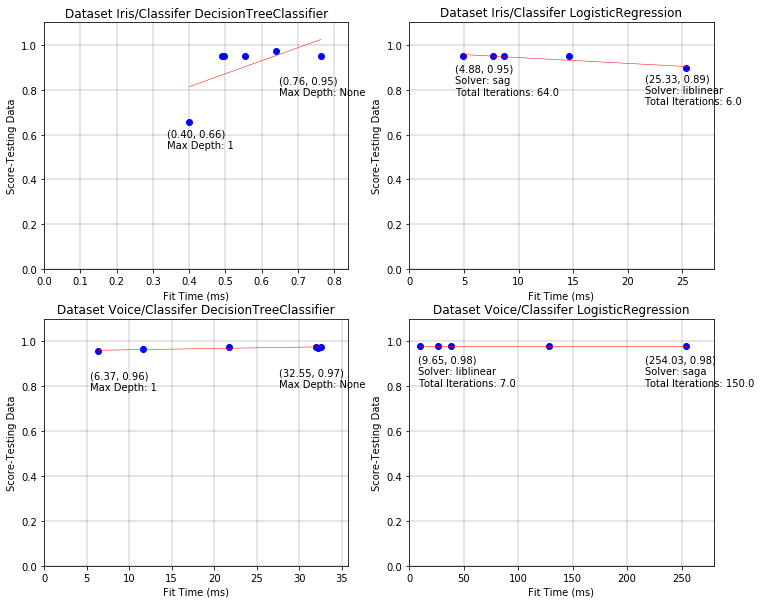

In [35]:
# Plot Classification Performance results
fig1 = plt.figure(figsize=(12,10))
ax_list = []
p_i = 0

for p_info in p_info_list:
    ax_list.append( fig1.add_subplot(2, math.ceil(len(p_info_list)/2), p_i+1) )
    create_plot(ax_list[p_i], p_info)
    p_i += 1
    
    
# Save the image - use it for Summary of Analysis at the top of the notebook
plt.savefig('docs/Comparison_DecisionTree_vs_LogisticRegression.png', bbox_inches='tight')

In [36]:
overall_df

,Dataset,Classifier,Solver,Iterations,Total Iterations,Max Tree Depth,Fit Time (ms),Score-Testing Data,Score-Training Data
0,Iris,DecisionTreeClassifier,NaN,NaN,NaN,None,0.7630,0.947368,1.000000
1,Iris,DecisionTreeClassifier,NaN,NaN,NaN,16,0.5538,0.947368,1.000000
2,Iris,DecisionTreeClassifier,NaN,NaN,NaN,8,0.4953,0.947368,1.000000
3,Iris,DecisionTreeClassifier,NaN,NaN,NaN,4,0.6385,0.973684,0.973214
4,Iris,DecisionTreeClassifier,NaN,NaN,NaN,2,0.4899,0.947368,0.955357
5,Iris,DecisionTreeClassifier,NaN,NaN,NaN,1,0.4002,0.657895,0.669643
6,Iris,LogisticRegression,liblinear,[6],6.0,NaN,25.3302,0.894737,0.901786
7,Iris,LogisticRegression,newton-cg,"[10, 7, 8]",25.0,NaN,14.6039,0.947368,0.910714
8,Iris,LogisticRegression,lbfgs,"[13, 14, 15]",42.0,NaN,7.6848,0.947368,0.910714
9,Iris,LogisticRegression,sag,"[22, 24, 18]",64.0,NaN,4.8775,0.947368,0.910714
